# Test case with Image Processing

## Baseline

Import supplyment library and function

In [44]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [45]:
# Because opencv reads images in BGR format, we need to convert it to RGB format
def cnvShowImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

# Image slicer
def imgSlicer(img, type = 'd8'):
    # Slice ratio (base on 1920x1536)
    slice_ratio = {
        'd2': [960, 768, 2],
        'd4': [480, 384, 4],
        'd8': [240, 192, 8],
        'd16': [120, 96, 16],
    }
    # Slice image
    img_slice = []
    x = 0
    y = 0
    for i in range(0, slice_ratio[type][2]):
        for j in range(0, slice_ratio[type][2]):
            temp = img[y:y+slice_ratio[type][1]-1, x:x+slice_ratio[type][0]-1]
            img_slice.append(temp)
            x += slice_ratio[type][0]
        x = 0
        y += slice_ratio[type][1]
    return img_slice

# Plot Histogram of image
def plotHistogram(img):
    plt.hist(img.ravel(), 256, [0,256], color='crimson')
    plt.ylabel("Number Of Pixels", color='crimson')
    plt.xlabel("Pixel Intensity- From 0-255", color='crimson')
    plt.title("Histogram Showing Pixel Intensity And Corresponding Number Of Pixels", color='crimson')
    plt.show()

# Create a mask
edge_detection_K = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpening_K = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])

Get file path

In [46]:
root = 'Immunofluorescence images/DAPI'
files = os.listdir(root)
files.sort()
if '.DS_Store' in files:    # for macOS file system
    files.remove('.DS_Store')
paths = []
for path in files:
    path = root + '/' + path
    paths.append(path)
print(paths[0:3])
print(len(paths))

['Immunofluorescence images/DAPI/1H_Nrf2_No_ADT_1_DAPI.tif', 'Immunofluorescence images/DAPI/1H_Nrf2_No_ADT_2_DAPI.tif', 'Immunofluorescence images/DAPI/1H_Nrf2_No_ADT_3_DAPI.tif']
197


Preview image

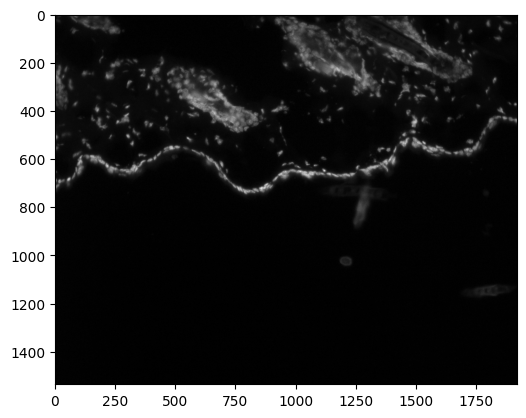

In [47]:
# read images
source = paths[22]
img = cv2.imread(source, 0)
plt.imshow(img, cmap='gray')
plt.show()

### Preprocessing
- CLAHE
- Gaussian & Median blur

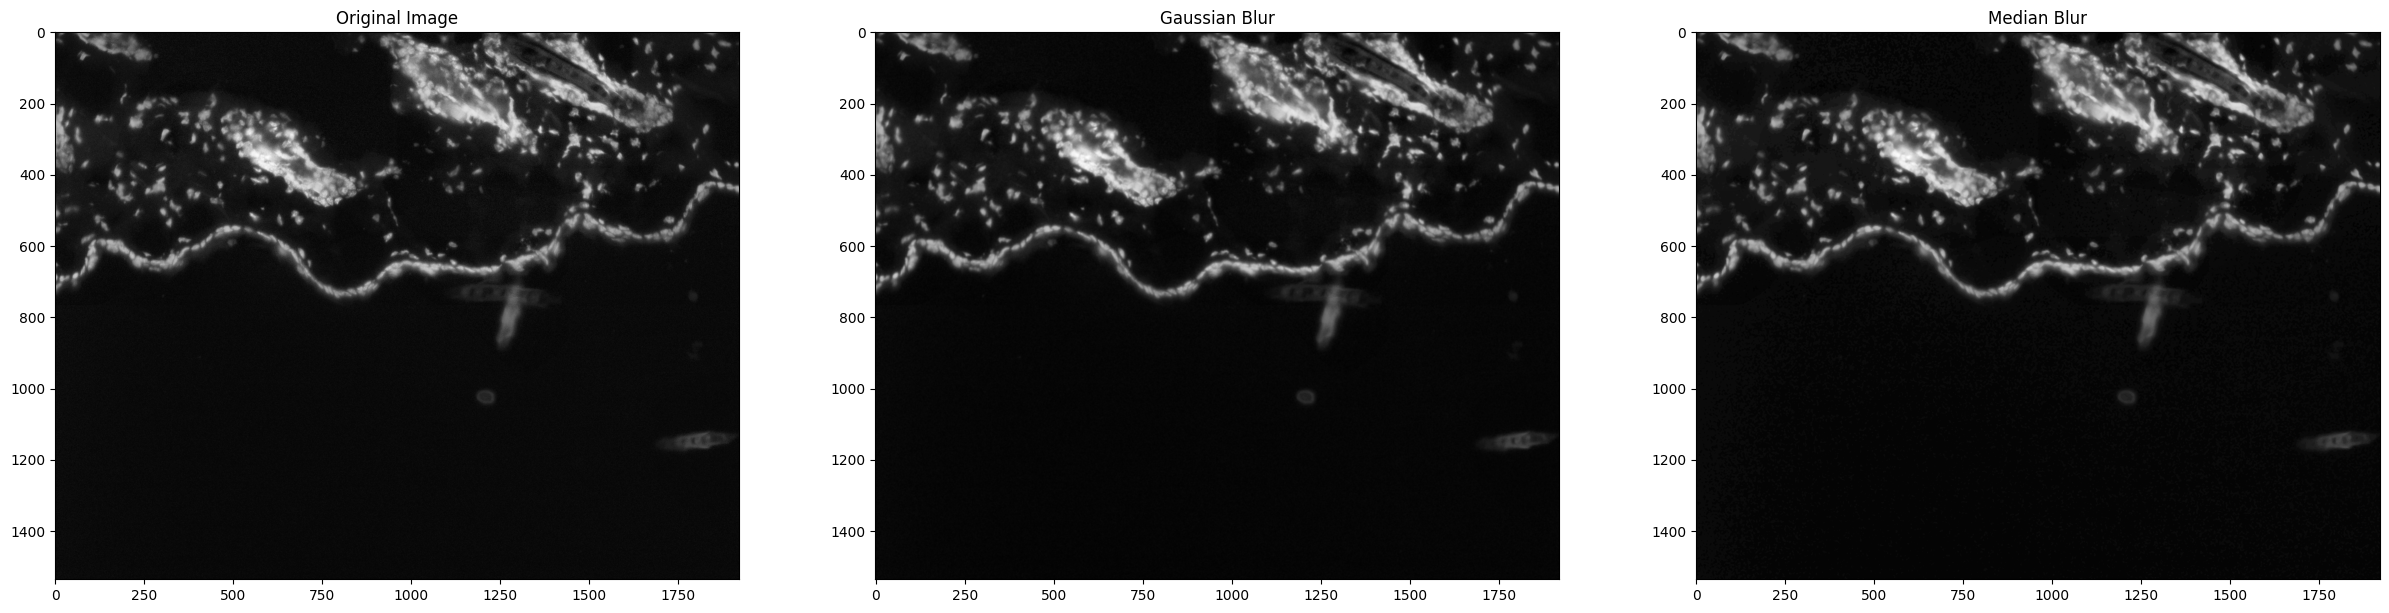

In [59]:
# create CLAHE
img = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img)
# Add Gaussian blur
img_gssblur = cv2.GaussianBlur(img, (5,5), 0)
# Add Median blur
img_mdbblur = cv2.medianBlur(img, 5)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_gssblur, cmap='gray')
ax[1].set_title('Gaussian Blur')
ax[2].imshow(img_mdbblur, cmap='gray')
ax[2].set_title('Median Blur')
plt.show()

Use NAFNet

In [65]:
import torch
import torchvision

from basicsr.models import *
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import *
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
    mg = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
    fig = plt.figure(figsize=(25, 10))
    ax1 = fig.add_subplot(1, 2, 1) 
    plt.title('Input image', fontsize=16)
    ax1.axis('off')
    ax2 = fig.add_subplot(1, 2, 2)
    plt.title('NAFNet output', fontsize=16)
    ax2.axis('off')
    ax1.imshow(img1)
    ax2.imshow(img2)

def single_image_inference(model, img, save_path):
    model.feed_data(data={'lq': img.unsqueeze(dim=0)})

    if model.opt['val'].get('grids', False):
        model.grids()

    model.test()

    if model.opt['val'].get('grids', False):
        model.grids_inverse()

    visuals = model.get_current_visuals()
    sr_img = tensor2img([visuals['result']])
    imwrite(sr_img, save_path)


Gaussian blur histogram

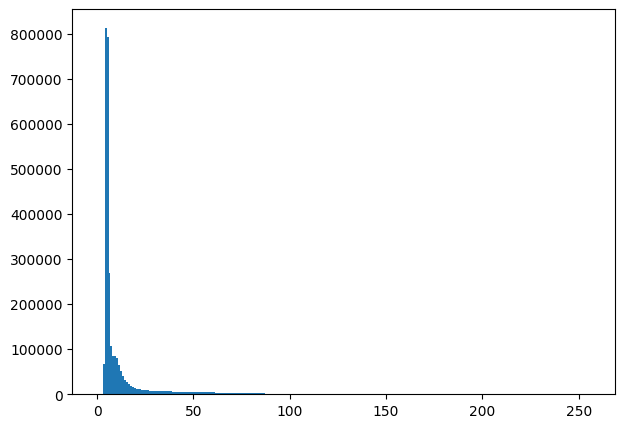

In [58]:
plt.figure(figsize=(7, 5))
plt.hist(img_gssblur.ravel(),256,[0,256])
plt.show()

threshold_multiotsu:  34
threshold_multiotsu:  88


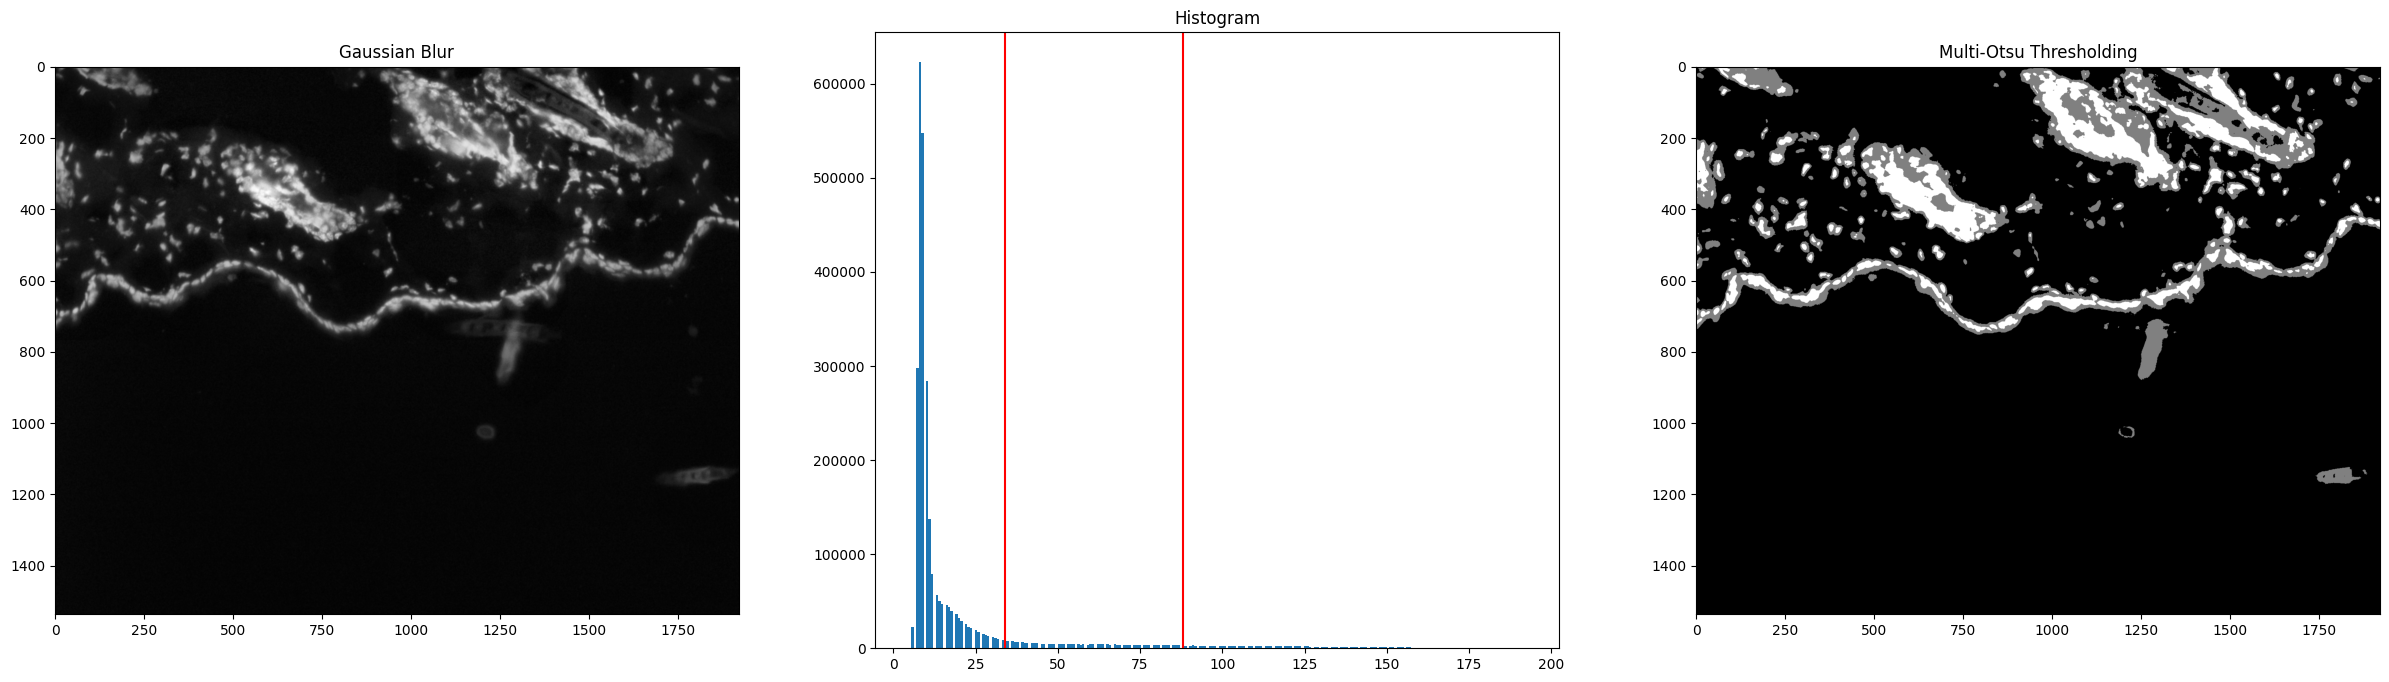

In [62]:
from skimage import data
from skimage.filters import threshold_multiotsu

# Applying multi-Otsu threshold for the default value, generating three classes.
thres = threshold_multiotsu(img_gssblur, classes=3)
# Using the threshold values, we generate the three regions.
regions = np.digitize(img_gssblur, bins=thres)

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
# Plotting the original image.
ax[0].imshow(img_gssblur, cmap='gray')
ax[0].set_title('Gaussian Blur')
# Plotting the histogram and the two thresholds obtained from multi-Otsu.
ax[1].hist(img_gssblur.ravel(), bins=255)
ax[1].set_title('Histogram')
for t in thres:
    ax[1].axvline(t, color='r')
    print('threshold_multiotsu: ', t)
# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='gray')
ax[2].set_title('Multi-Otsu Thresholding')
plt.show()